<div class="alert alert-warning">
This is an exercise to be handed in on Peergrade
</div>

In [26]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))

import torch
cuda = torch.cuda.is_available()

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

In [11]:

test = torch.Tensor(2,4,5)
print(test.shape)
test2 = torch.reshape(test,[2,-1])
print(test2.shape)




torch.Size([2, 4, 5])
torch.Size([2, 20])


In [36]:
import torch.nn as nn
from torch.nn.functional import softplus
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, Dropout2d, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax, dropout, dropout2d
import time


# define size variables
height = 224
width = 224
channels = 1
num_features = 224**2

# Regulization
L2_reg = 1e-6


# For the convolutional part
conv_out_channels_1 = 4
conv_stride_1 = 1
kernel_size_1 = 5
pool_stride_1 = 2
conv_out_channels_2 = 8
conv_stride_2 = 1
kernel_size_2 = 5
pool_stride_2 = 2

######## image has to be: (num, channels, heigh, width)!!!! #########
class CNN_VAE(nn.Module):
    def __init__(self, latent_features, num_samples):
        super(CNN_VAE, self).__init__()
        
        self.latent_features = latent_features
        self.num_samples = num_samples
  
        ## CNN decoder
        self.encoder = nn.Sequential(
            Conv2d(in_channels=channels,
                             out_channels=conv_out_channels_1,
                             kernel_size=kernel_size_1,
                             stride=conv_stride_1,
                             padding=2),
            MaxPool2d(kernel_size=3, stride=pool_stride_1,padding=0),
            ReLU(),
            BatchNorm2d(conv_out_channels_1),
            Dropout2d(p=0.2),
            Conv2d(in_channels=conv_out_channels_1,
                             out_channels=conv_out_channels_2,
                             kernel_size=kernel_size_2,
                             stride=conv_stride_2,
                             padding=2),
            MaxPool2d(kernel_size=3,
                                stride=pool_stride_1,
                                padding=0),
            ReLU(),
            BatchNorm2d(conv_out_channels_2),
            Dropout2d(p=0.2)
        )
        
        self.CNN_to_latent = Linear(in_features=24200, out_features=self.latent_features*2)
        
        # The latent code must be decoded into the original image
        self.decoder = nn.Sequential(
            nn.Linear(in_features=self.latent_features, out_features=128),
            nn.ELU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ELU(),
            nn.Linear(in_features=256, out_features=num_features)
        )
        

    def forward(self, x): 
        outputs = {}
        
        # Split encoder outputs into a mean and variance vector
        #mu, log_var = torch.chunk(self.encoder(x), 2, dim=-1)
        x = self.encoder(x)
        x = x.view(num_samples,-1)
        x = self.CNN_to_latent(x)
        mu, log_var = torch.chunk(x, 2, dim=-1)
        
        
        # Make sure that the log variance is positive
        log_var = softplus(log_var)
        
        # :- Reparametrisation trick
        # a sample from N(mu, sigma) is mu + sigma * epsilon
        # where epsilon ~ N(0, 1)
                
        # Don't propagate gradients through randomness
        with torch.no_grad():
            batch_size = mu.size(0)
            epsilon = torch.randn(batch_size, self.num_samples, self.latent_features)
            
            if cuda:
                epsilon = epsilon.cuda()
        
        sigma = torch.exp(log_var/2)
        
        # We will need to unsqueeze to turn
        # (batch_size, latent_dim) -> (batch_size, 1, latent_dim)
        z = mu.unsqueeze(1) + epsilon * sigma.unsqueeze(1)        
        
        # Run through decoder
        x = self.decoder(z)
        
        # The original digits are on the scale [0, 1]
        x = torch.sigmoid(x)
        
        # Mean over samples
        x_hat = torch.mean(x, dim=1)
        
        outputs["x_hat"] = x_hat
        outputs["z"] = z
        outputs["mu"] = mu
        outputs["log_var"] = log_var
        
        return outputs


latent_features = 2
num_samples = 10  # number of samples in batch 

net = CNN_VAE(latent_features, num_samples)

# Transfer model to GPU if available
if cuda:
    net = net.cuda()

print(net)

## test with dummy data

test_data = torch.Tensor(num_samples,channels,height,width)
print(test_data.shape)
x_test = net(test_data)


CNN_VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout2d(p=0.2)
    (5): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout2d(p=0.2)
  )
  (CNN_to_latent): Linear(in_features=24200, out_features=4, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=50176, bias=True)
  )
)
torch.Size([10, 1, 224, 224])


Following we define the PyTorch functions for training and evaluation.

In [37]:
from torch.nn.functional import binary_cross_entropy
from torch import optim

def ELBO_loss(y, t, mu, log_var):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    kl = -0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1)

    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - torch.mean(kl)
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl.sum()


# define our optimizer
# The Adam optimizer works really well with VAEs.
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = ELBO_loss

Test the forward pass, to check that everything is in order.

In [38]:
from torch.autograd import Variable

x, _ = next(iter(train_loader))
x = Variable(x)

if cuda:
    x = x.cuda()

outputs = net(x)

x_hat = outputs["x_hat"]
mu, log_var = outputs["mu"], outputs["log_var"]
z = outputs["z"]

loss, kl = loss_function(x_hat, x, mu, log_var)

print(x.shape)
print(x_hat.shape)
print(z.shape)
print(loss)
print(kl)

torch.Size([128, 784])
torch.Size([128, 784])
torch.Size([128, 10, 4])
tensor(544.3679, grad_fn=<NegBackward>)
tensor(84.4596, grad_fn=<SumBackward0>)


In the training loop we sample each batch and evaluate the error, latent space, and reconstructions on every epoch.

**NOTE** this will take a while on CPU.

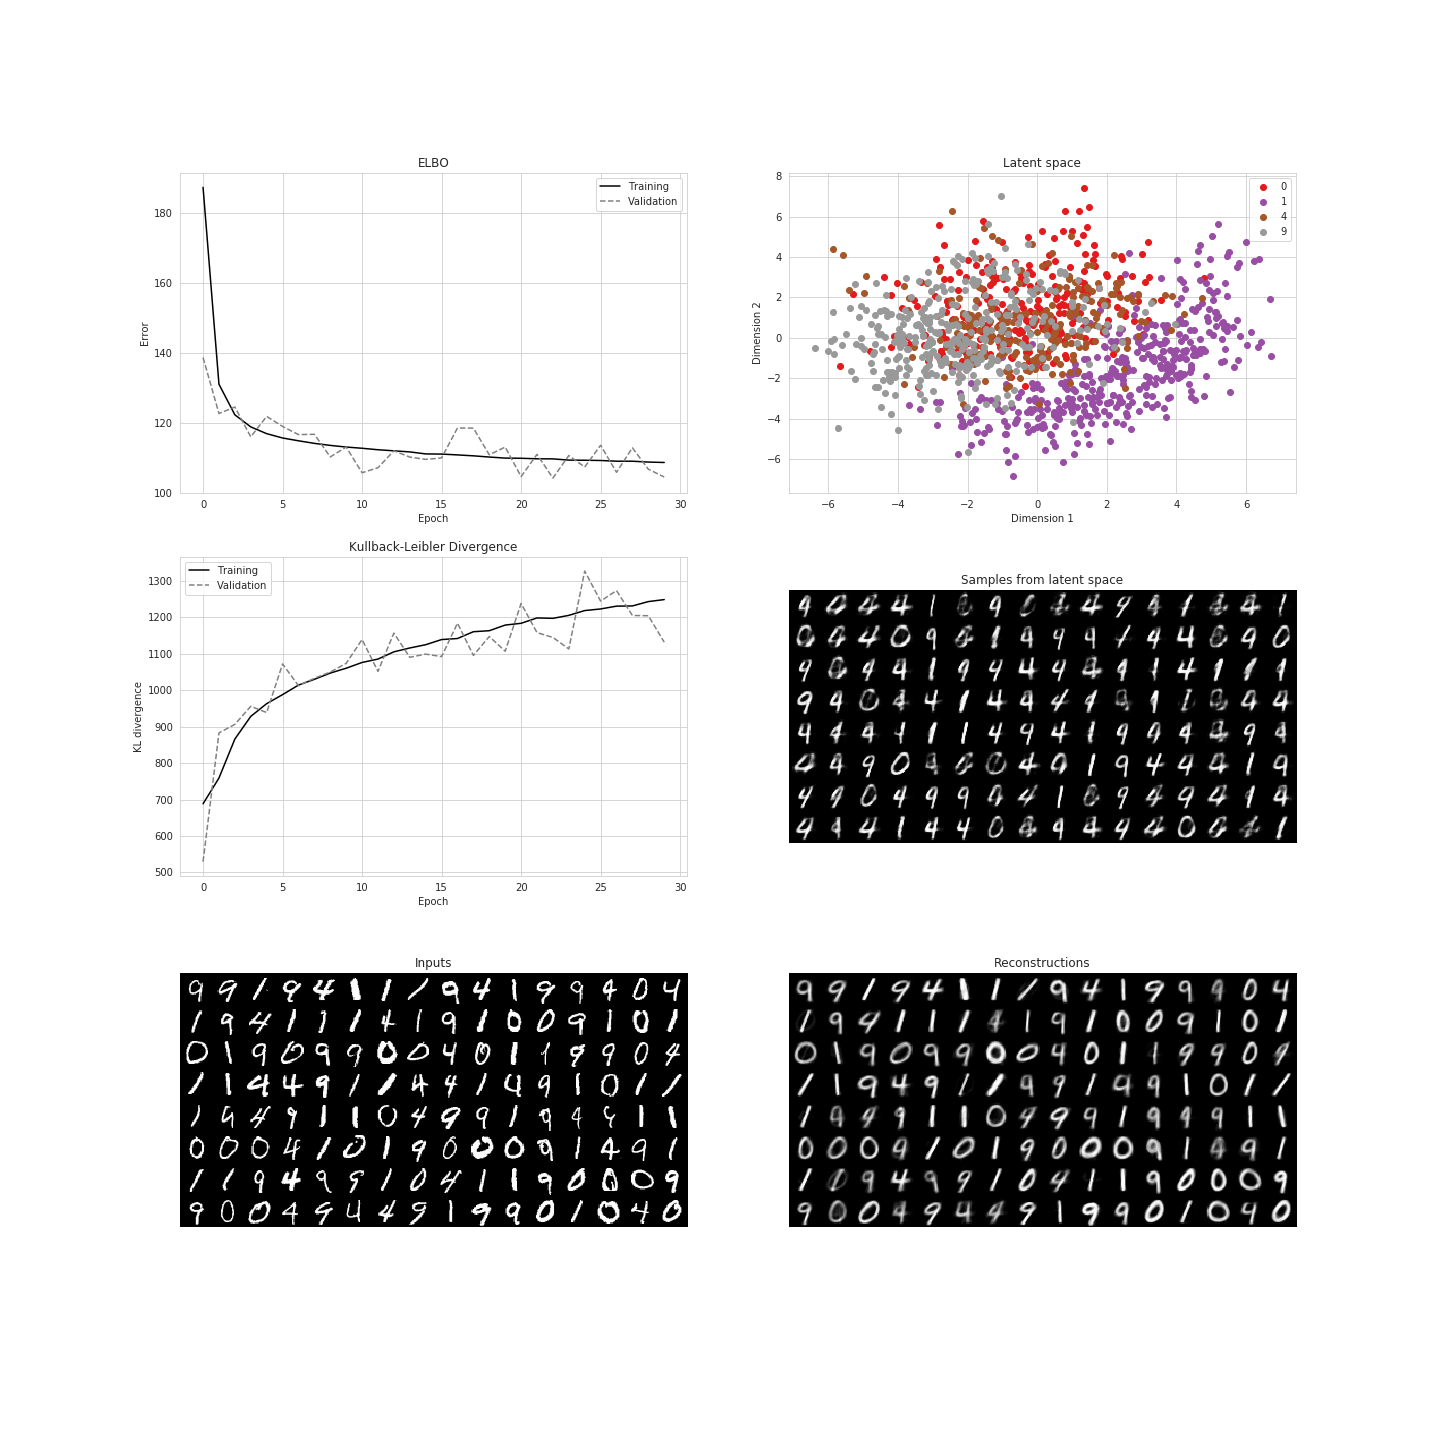

In [39]:
import os
from sklearn.decomposition import PCA


num_epochs = 30
tmp_img = "tmp_vae_out.png"
show_sampling_points = False

train_loss, valid_loss = [], []
train_kl, valid_kl = [], []

device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

for epoch in range(num_epochs):
    batch_loss, batch_kl = [], []
    net.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = Variable(x)
        
        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        
        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())

    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        net.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = Variable(x)
        
        x = x.to(device)
        
        outputs = net(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]
    
        elbo, kl = loss_function(x_hat, x, mu, log_var)
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()
        
        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch == 0:
        continue
    
    # -- Plotting --
    f, axarr = plt.subplots(3, 2, figsize=(20, 20))

    # Loss
    ax = axarr[0, 0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(epoch+1), train_loss, color="black")
    ax.plot(np.arange(epoch+1), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])

    # Latent space
    ax = axarr[0, 1]

    ax.set_title('Latent space')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    
    rows = 8
    columns = batch_size // rows
    
    span = np.linspace(-4, 4, rows)
    grid = np.dstack(np.meshgrid(span, span)).reshape(-1, 2)
    
    # If you want to use a dimensionality reduction method you can use
    # for example PCA by projecting on two principal dimensions

    z = PCA(n_components=2).fit_transform(z.reshape(-1,latent_features))
    z = z.reshape(batch_size,10,2)
#     print(z.shape)
#     print(z.reshape(-1,latent_features).shape)
    colors = iter(plt.get_cmap('Set1')(np.linspace(0, 1.0, len(classes))))
    for c in classes:
        ax.scatter(*z[c == y.numpy()].reshape(-1, 2).T, c=next(colors), marker='o', label=c)
        
    if show_sampling_points:
        ax.scatter(*grid.T, color="k", marker="x", alpha=0.5, label="Sampling points")

    ax.legend()
    
    # KL / reconstruction
    ax = axarr[1, 0]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(epoch+1), train_kl, color="black")
    ax.plot(np.arange(epoch+1), valid_kl, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    # Latent space samples
    ax = axarr[1, 1]
    ax.set_title('Samples from latent space')
    ax.axis('off')

    with torch.no_grad():
#         epsilon = torch.from_numpy(grid).float().to(device)
        epsilon = torch.randn(batch_size, latent_features).to(device)
        samples = torch.sigmoid(net.decoder(epsilon)).detach()

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Inputs
    ax = axarr[2, 0]
    ax.set_title('Inputs')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')

    # Reconstructions
    ax = axarr[2, 1]
    ax.set_title('Reconstructions')
    ax.axis('off')

    canvas = np.zeros((28*rows, columns*28))
    for i in range(rows):
        for j in range(columns):
            idx = i % columns + rows * j
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_hat[idx].reshape((28, 28))
    ax.imshow(canvas, cmap='gray')
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    clear_output(wait=True)

    os.remove(tmp_img)

# Analyzing the VAE

## Mandatory Exercises

- Experiment with the number of layers and activation functions in order to improve the reconstructions and latent representation. What solution did you find the best and why?
- Try to increase the number of digit classes in the training set and analyze the learning curves, latent space and reconstructions. For which classes and why does the VAE fail in reconstructing?  *HINT: Try the combination: `classes=[0, 1, 4, 9]`, to see how well VAE can separate these digits in the latent representation and reconstructions.*
- Increase the number of units in the latent layer. Does it increase the models representational power and how can you see and explain this? How does this affect the quality of the reconstructions? *HINT: You can visualize the latent space in 2D by transforming z to a lower dimensional representation with [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) or [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)*

**Answers**:
 - ELU activation function performs a little bit better, other functions performs worse
 - More layers doesn't really make a huge difference 
 
 - I seems like the VAE have a hard time learning the difference between 4 and 9 since they look a lot alike. This is also evident from the PCA plot, that 4 and 9 are not well seperated.
 
 - Increasing latent units from 4 to 8 does not really make difference (by looking at the PCA and samples from latent space). Maybe it can produce slightly better 9's and 4's, but are in general more confused. The loss decrease since the KL-term is set to 0.
 
 
### 2. Analyze the purpose of the KL-term

- How does the KL-term, $KL[q(z|x)||p(z)]$, work as a regulariser on the distributions over latent variables? *HINT*: When maximising the ELBO, the probability-distance measure is minimised $KL[q(z|x)||p(z)] \rightarrow 0$ so that $q(z|x) \rightarrow p(z) = \mathcal{N}(z|0,I)$ for all examples, x. At $KL[q(z|x)||p(z)] = 0$ variations in x stops having an affect on the latent distribution and latent units are all described by the same distribution, $\mathcal{N}(z|0,I)$, so they produce a noisy output without signal $z=\epsilon$ to the decoder.
- Try removing the KL-term ($KL \cdot 0$ in `ELBO_loss`) and analyze what happens during training, in the learning curves, latent representation and reconstructions compared to before removing it.
- Notice what the loss reduces to and explain how this can affect a VAE. *HINT*: Compare loss function for AE and VAE, and remember that we can use the pixel-wise binary crossentropy error as the loss in the AEs and for the reconstruction error, $\log p(x|z) = \log Ber(\mu_\phi(z))$, in VAEs.

**Answers**:
 - The KL-term will drive the distribution of the latent state towards a normalt distribution with zero mean and a variance. Collectively, this distribution describes the joint distribution behind the MNIST digits. So the loss increases if the distribution of p(z) is longer from a normal distribution.
 - When  removing the KL-term, we see very noisy samples from the latent space which does not really depict digits clearly 

### 3. Sampling in the VAE

- Explain how one could implement multiple samples in the VAE and how that would improve learning. *HINT*: Look into how the samples are drawn in the definition of the `VariationalAutoencoder` class.
- Experiment with `num_samples` used when initialising the VAE. Does it improve the reconstructions and how/why?

**Answers**:

- One way to iplement multiple samples is to use the reparametrisation trick. That means that a sample from $N(\mu,\sigma)$ is $\mu+\sigma*\epsilon$ where $\epsilon \sim \mathcal{N}(0,1)$. Therefore $z$ is determined deterministically. We can thus take derivatives of functions involving $z$, $f(z)$ with respect to the parameters of its distribution $\mu$ and $\sigma$. The reparametrization trick therefore lets us backpropagate through the ELBO which is a function of samples of the latent variables $z$.
- Increasing the number of samples used when initializing the VAE, decrease the ELBO error when training the network. The number of samples is used in the reparametrization trick and it denotes the number of samples (z) that is to be drawn to train the decoder. As mentioned before $\epsilon$ is included in each sample, and increasing the number of samples therefore means that representation of each sample is more normally distributed. 

## Optional exercises

- OPT: Use the original paper http://arxiv.org/pdf/1312.6114v10.pdf or [this blog](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) to explain what the reparameterization trick does.
- OPT: Look through https://arxiv.org/abs/1611.00712 or https://arxiv.org/abs/1611.01144 and explain how one could instead introduce a categorical latent variable for $z$.
- OPT: Implement the Gumbel softmax trick thereby letting $z$ take a categorical distribution.
- OPT: The VAE is a probablistic model. We could model $p(x,z,y)$ where $y$ is the label information. Explain how this model could handle semi-supervised learning? You can look through the papers https://arxiv.org/pdf/1406.5298.pdf or  https://arxiv.org/pdf/1602.05473v4.pdf or again the two papers on Gumbel softmax.

**Answers**:

### The tradeoff connection between the lower bound and KL-divergence
To understand this tradeoff connection, we flip the whole problem around into the perspective of the KL-divergence

$KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)}{p(z|x)}dz = \mathbb{E}_{q(z|x)}\left[\log \frac{q(z|x)}{p(z|x)}\right]$,

which is a non-negative distance measure between distributions, so by minimising it wrt. to the parameters in $q(z|x)$, the distribution moves close to our unknown $p(z|x)$. But as $p(z|x)$ is unknown and would include some rather intractable integrals over neural networks, we can instead get rid of it by expressing it through Bayes rule $p(z|x) = p(x|z)p(z)/p(x)$ and thereby decompose the KL-divergence into our log-likelihood and lower bound:

$ KL[q(z|x) || p(z|x)] = \int_z q(z|x)\log \frac{q(z|x)p(x)}{p(x|z)p(z)}dz = \int_z q(z|x)\log \frac{q(z|x)}{p(x|z)p(z)}dz + \log p(x)$ 

by seeing that the likelihood, $p(x)$, is independent of $z$ and pull it out of the integral. We can flip the sign and fraction in the integral term to recognise it as the negative lower bound

$KL[q(z|x) || p(z|x)] = - \int_z q(z|x)\log \frac{p(x|z)p(z)}{q(z|x)}dz + \log p(x) =  -\mathcal{L}(x) + \log p(x)$

We then find the log-likelihood to consist of the two terms and hold the inequality

$\log p(x) =  KL[q(z|x) || p(z|x)] + \mathcal{L}(x) \geq \mathcal{L}(x)$

where the KL-divergence is non-zero and the log-likelihood is $\log p(x) \leq 0$. This means that maximising the lower bound from the negative domain towards $0$ will also maximise the log-likelihood, while pushing down the KL-divergence until $q(z|x)$ cannot move closer to natures true distribution, $p(z|x)$. So how close the lower bound can get to the log-likelihood is dependent on the flexibility of the distribution we choose for $q(z|x)$. 

## Michael Nielsen book exercise of own choice
Pick an exercise of own choice from Michael Nielsens book
    
 **Asignment from book**
 
Eq. BP3 and BP4 has to be proven in this exercise

BP3: $\frac{\partial C}{\partial b_{j}^l} = \delta_{j}^l$. 

Using the chainrule this can be expressed this as: $ \frac{\partial C}{\Delta b_{j}^l} = \frac{\partial C}{\partial z_{j}^l} \frac{\partial z_{j}^l}{\partial b_{j}^l}$. 

We can now use the definition: $\delta_l^j$, i.e. $\delta_l^j = \frac{\partial C}{\partial z_{j}^l}$, and that $\frac{\partial z_{j}^l}{\partial b_{j}^l} = 1$, when $z = wa+b$, which yields: $\frac{\partial C}{\partial b_{j}^l} = \delta_l^j \cdot 1 = \delta_l^j$

BP4: $ \frac{\Delta C}{\Delta w_{jk}^l} = a_k^{l-1}\delta_j^l$. 

We again use the chainrule to yield: $ \frac{\partial C}{\Delta w_{jk}^l} = \frac{\partial C}{\partial z_{j}^l} \frac{\partial z_{j}^l}{\partial w_{jk}^l}$. We Substitute again: $\frac{\partial C}{\partial z_{j}^l} $ with $\delta_l^j$, and differentiate $\frac{\partial z_{j}^l}{\partial w_{jk}^l} = a_k^{l-1}$, which leads to: $ \frac{\Delta C}{\Delta w_{jk}^l} = a_k^{l-1}\delta_j^l$

## Credits 

> Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow and updated by 
Maximillian F. Vording ([maximillian91](https://github.com/maximillian91)).
Converted to PyTorch and updated by Jesper Wohlert ([wohlert](https://github.com/wohlert)).